In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn import preprocessing

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
from os.path import exists as DoesPathExist
train_logs_path = "/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv"
train_scores_path = "/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv"
test_logs_path = "/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv"
sample_submission_path = "/kaggle/input/linking-writing-processes-to-writing-quality/sample_submission.csv"

if DoesPathExist(train_logs_path):
    train_logs: pd.DataFrame = pd.read_csv(train_logs_path)
else:
    train_logs: pd.DataFrame = pd.read_csv("./data/train_logs.csv")

if DoesPathExist(train_scores_path):
    train_scores = pd.read_csv(train_scores_path)
else:
    train_scores = pd.read_csv("./data/train_scores.csv")

if DoesPathExist(test_logs_path):
    test_logs = pd.read_csv(test_logs_path)
else:
    test_logs = pd.read_csv("./data/test_logs.csv")
    
if DoesPathExist(sample_submission_path):
    sample_submission = pd.read_csv(sample_submission_path)
else:
    sample_submission = pd.read_csv("./data/sample_submission.csv")
    
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('expand_frame_repr', False)

In [30]:
train_logs.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1


In [31]:
train_scores.head()

,id,score
0,001519c8,3.5
1,0022f953,3.5
2,0042269b,6.0
3,0059420b,2.0
4,0075873a,4.0


In [32]:
train_logs.describe(percentiles=[0.02, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).round(0)

,event_id,down_time,up_time,action_time,cursor_position,word_count
count,8405898.0,8405898.0,8405898.0,8405898.0,8405898.0,8405898.0
mean,2068.0,793560.0,793658.0,98.0,1223.0,231.0
std,1588.0,514945.0,514943.0,253.0,949.0,176.0
min,1.0,106.0,252.0,0.0,0.0,0.0
2%,69.0,65612.0,65707.0,0.0,27.0,6.0
5%,171.0,109978.0,110076.0,12.0,87.0,18.0
25%,852.0,373184.0,373282.0,66.0,499.0,96.0
50%,1726.0,720886.0,720980.0,93.0,1043.0,200.0
75%,2926.0,1163042.0,1163141.0,122.0,1706.0,327.0
95%,5121.0,1664020.0,1664111.0,176.0,3037.0,565.0


## Data Analysis

#### Word Count Analysis
Here we will be looking at the effect of the word count on the outcome.

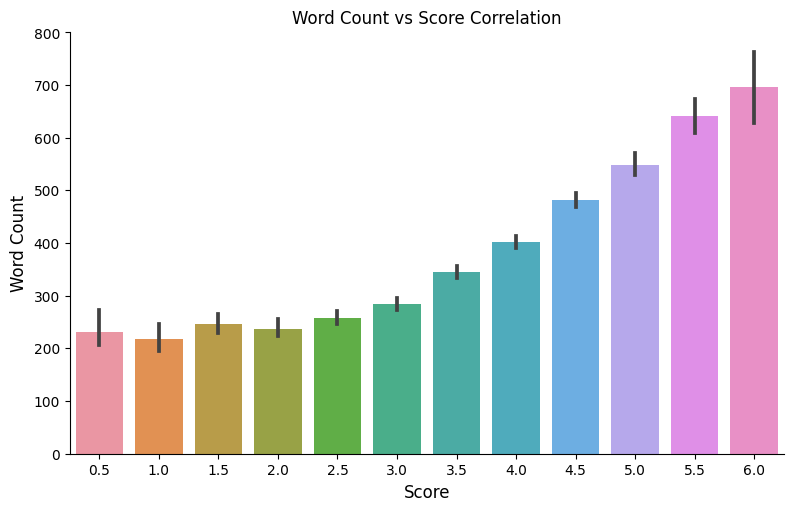

In [33]:
stats = train_logs.groupby("id")["word_count"].max().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="word_count", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Word Count', fontsize=12)
plt.title("Word Count vs Score Correlation")
plt.show()

In [34]:
stats.describe(percentiles=[0.02, 0.05, 0.25, 0.5, 0.75, 0.95, 0.98]).round(1)

,word_count
count,2471.0
mean,390.0
std,172.5
min,35.0
2%,201.0
5%,204.0
25%,255.0
50%,351.0
75%,480.0
95%,724.0


#### Event Analysis

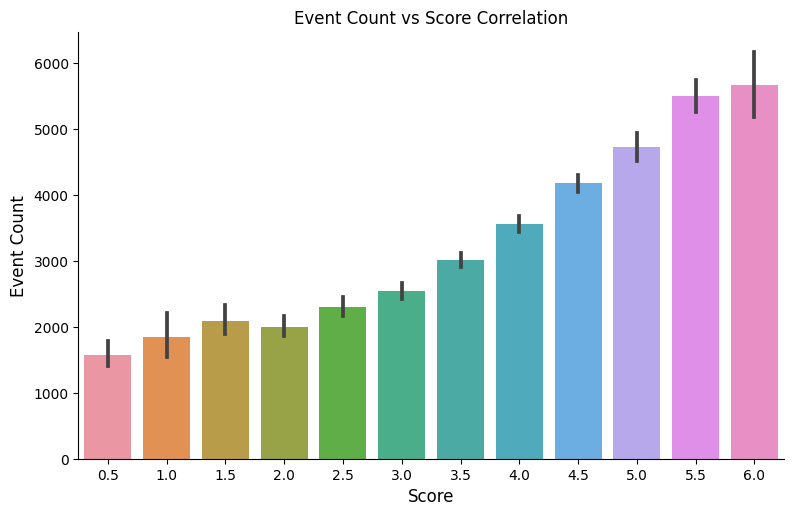

In [35]:
stats = train_logs.groupby("id")["event_id"].max().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="event_id", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Event Count', fontsize=12)
plt.title("Event Count vs Score Correlation")
plt.show()

In [36]:
stats.describe(percentiles=[0.02, 0.05, 0.25, 0.5, 0.75, 0.95, 0.98]).round(1)

,event_id
count,2471.0
mean,3401.8
std,1578.9
min,262.0
2%,1377.8
5%,1524.5
25%,2193.5
50%,3082.0
75%,4301.0
95%,6387.5


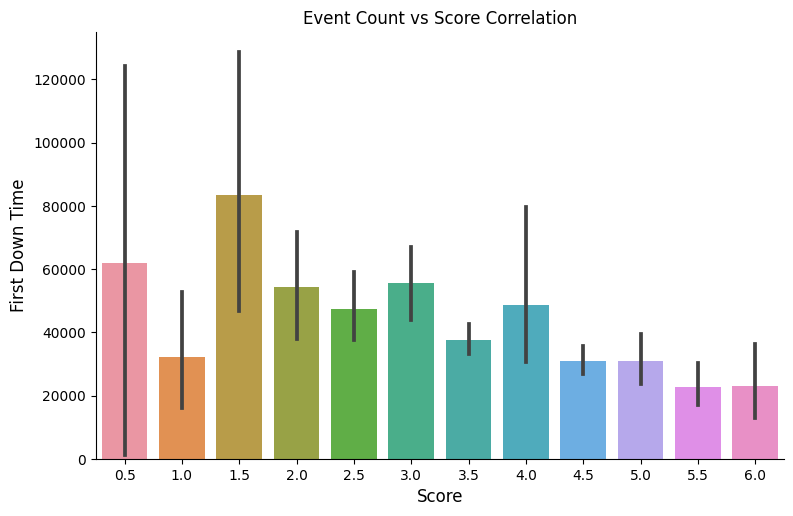

In [37]:
stats = train_logs.groupby("id")["down_time"].min().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="down_time", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('First Down Time', fontsize=12)
plt.title("Event Count vs Score Correlation")
plt.show()

## Data preprocessing

#### Splitting the ids into training and validation sets.

In [38]:
uniqueIds = pd.Series(train_logs["id"].unique())
valid_ids = uniqueIds.sample(int(train_logs["id"].nunique()*0.2))
train_ids = np.setdiff1d(train_logs["id"], valid_ids)
valid_ids = np.setdiff1d(train_logs["id"], train_ids)

#### Calculating values to consitently normalization and outlier removeal

In [39]:
# Removal of lines above these numbers.
MAX_EVENT_START_TIME = 1_800_000 # miliseconds in 30 minutes.
MAX_ACTION_DURATION = 250 # Based on 99th percentile.

# TOP is the value all the other values are divided by to the vast majority of the data from [0, 1]
WORD_COUNT_TOP = 850 # Based on 98th percentile.
CURSOR_POSITION_TOP = 4000 # Based on the 99th percentile.

#### Converting to an image

In [40]:
NUMBER_OF_INTERVALS = 7_200 # 7_200 = 1_800_000 msec / 0.25 second intervals

def EssayToImage(df: pd.DataFrame) -> []:
    """Converts an essay into an "image". Aka, a dataframe with 8 columns and rows equal to NUMBER_OF_INTERVALS. Note, for speed reasons, this will drop some columns.

    Args:
        df (pd.DataFrame): The dataframe of a SINGLE ID to input.

    Returns:
        pd.DataFrame: The resulting dataframe.
    """
    nonproduction = np.zeros(NUMBER_OF_INTERVALS)
    input = np.zeros(NUMBER_OF_INTERVALS)
    remove = np.zeros(NUMBER_OF_INTERVALS)
    paste = np.zeros(NUMBER_OF_INTERVALS)
    replace = np.zeros(NUMBER_OF_INTERVALS)
    move = np.zeros(NUMBER_OF_INTERVALS)
    cursor = np.zeros((NUMBER_OF_INTERVALS, 1))
    words = np.zeros(NUMBER_OF_INTERVALS)

    downtime_start = df["down_time"].min()

    for index, row in df.iterrows():
        adjusted_downtime = row.down_time - downtime_start

        if adjusted_downtime > MAX_EVENT_START_TIME:
            continue

        down_index = int(adjusted_downtime / NUMBER_OF_INTERVALS)
        up_index = int(adjusted_downtime / NUMBER_OF_INTERVALS) + 1 # + 1 makes the switch case cleaner
        action = row.activity

        np.append(cursor[up_index-1], row.cursor_position / CURSOR_POSITION_TOP)
        if words[down_index:up_index] < row.word_count / WORD_COUNT_TOP:
            words[down_index:up_index] = row.word_count / WORD_COUNT_TOP

        match action:
            case "Nonproduction":
                nonproduction[down_index:up_index] += 1.0
            case "Input":
                input[down_index:up_index] += 1.0
            case "Remove/Cut":
                remove[down_index:up_index] += 1.0
            case "Paste":
                paste[down_index:up_index] += 1.0
            case "Replace":
                replace[down_index:up_index] += 1.0
            case _:
                if "Move From" in action:
                    move[down_index:up_index] += 1.0
    
    cursor = np.delete(cursor, 0).mean()
    return pd.DataFrame({
        "nonproduction" : np.float64(nonproduction),
        "input" : np.float64(input),
        "remove": np.float64(remove),
        "paste": np.float64(paste),
        "replace": np.float64(replace),
        "move": np.float64(move),
        "cursor": np.float64(cursor),
        "word_count": np.float64(words)
    })
    return [nonproduction, input, remove, paste, replace, move, cursor, words]

In [41]:
train_dfs = {id: EssayToImage(df) for id, df in train_logs.groupby("id") if id in train_ids}
#train_x = [EssayToImage(df) for id, df in train_logs.groupby("id") if id in train_ids]

In [42]:
train_scores_dict = {row[1]["id"]: row[1]["score"] for row in train_scores.iterrows() if row[1]["id"] in train_ids}

In [43]:
print("Assertion Checking Started")
assert list(train_dfs.keys()).sort() == train_ids.sort()
assert list(train_scores_dict.keys()).sort() == train_ids.sort()
assert len(train_scores_dict.keys()) == len(train_ids), "Scores dictionary does not contain all training ids"
assert len(train_dfs.keys()) == len(train_ids), "Train dataframe dictionary does not contain all training ids"
print("Passed Assertions!")

Assertion Checking Started
Passed Assertions!


In [44]:
tf.convert_to_tensor(train_dfs.get("946479b3").T, dtype=np.float64)

<tf.Tensor: shape=(8, 7200), dtype=float64, numpy=
array([[1.00000000e+00, 0.00000000e+00, 2.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.80000000e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 4.70588235e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])>

In [45]:
def OneHotEncoding(n: float):
    result = [0]*12
    result[int(n / 0.5) - 1] = 1
    return result

x_train = np.empty(shape=(len(train_ids), 8, 7200), dtype=tf.Tensor)
y_train = np.empty(shape=len(train_ids), dtype=type(np.array))
for index, id in enumerate(train_ids):
    x_train[index] = tf.convert_to_tensor(train_dfs.get(id).T, dtype=np.float64)
    print(x_train[index])
    y_train[index] = OneHotEncoding(train_scores_dict[id])

[[2.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 ...
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]]
[[3.0 0.0 2.0 ... 0.0 0.0 0.0]
 [18.0 6.0 18.0 ... 0.0 0.0 0.0]
 [0.0 11.0 3.0 ... 0.0 0.0 0.0]
 ...
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0035294117647058825 0.0035294117647058825 0.0058823529411764705 ...
  0.0 0.0 0.0]]
[[1.0 0.0 2.0 ... 0.0 0.0 0.0]
 [0.0 0.0 36.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 ...
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.00823529411764706 ... 0.0 0.0 0.0]]
[[1.0 0.0 1.0 ... 0.0 0.0 0.0]
 [0.0 0.0 16.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 ...
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0035294117647058825 ... 0.0 0.0 0.0]]
[[2.0 0.0 0.0 ... 0.0 0.0 0.0]
 [6.0 2.0 16.0 ... 0.0 0.0 0.0]
 [0.0 8.0 2.0 ... 0.0 0.0 0.0]
 ...
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0

In [46]:
print(x_train[0])
print(y_train[0])
print(x_train.shape)
print(x_train[0].shape)

[[2.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 ...
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
(1977, 8, 7200)
(8, 7200)


In [47]:
valid_dfs = {id: EssayToImage(df) for id, df in train_logs.groupby("id") if id in valid_ids}
valid_scores_dict = {id: df["score"] for id, df in train_scores.groupby("id") if id in valid_ids}
#valid_scores_dict = {row[1]["id"]: row[1]["score"] for row in train_scores.iterrows() if row[1]["id"] in valid_ids}

print(f"Valid Id: {len(valid_ids)}")
print(f"Dataframe: {len(valid_dfs.keys())}")
print(f"Scores: {len(valid_scores_dict.keys())}")

assert len(valid_scores_dict.keys()) == len(valid_ids), "Scores dictionary does not contain all valid ids"
assert len(valid_dfs.keys()) == len(valid_ids), "Train dataframe dictionary does not contain all valid ids"

x_valid = np.empty(shape=len(valid_ids), dtype=type(pd.DataFrame))
y_valid = np.empty(shape=len(valid_ids), dtype=type(np.array))
for index, id in enumerate(valid_ids):
    x_valid[index] = valid_dfs[id]
    y_valid[index] = OneHotEncoding(valid_scores_dict[id])

Valid Id: 494
Dataframe: 494
Scores: 494


/var/folders/tc/wt4t3d6s7cj2_wczz6yqs0zm0000gn/T/ipykernel_75122/3244911286.py:3: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  result[int(n / 0.5) - 1] = 1


In [48]:
input_shape = (len(train_ids), x_train[0].shape[0], x_train[0].shape[1],)
print(input_shape)
model = models.Sequential()
#model.add(layers.InputLayer(input_shape=(8, 7200), dtype=np.float64))
model.add(layers.Conv1D(filters=32, kernel_size = (3,), input_shape=(8, 7200), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(units=128,activation='relu'))
model.add(layers.Dense(units=128,activation='relu'))
model.add(layers.Dense(units=12,activation='relu'))

(1977, 8, 7200)


In [49]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 6, 32)             691232    
                                                                 
 flatten_1 (Flatten)         (None, 192)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               24704     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 12)                1548      
                                                                 
Total params: 733996 (2.80 MB)
Trainable params: 733996 (2.80 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [50]:
strategy = tf.distribute.MirroredStrategy(devices=None)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [51]:
#with strategy.scope():
model.compile(optimizer='adam', 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=['mean_squared_error'])

In [52]:
print(x_train.shape)
print(x_train[0].shape)
print(x_train[0][0].shape, x_train[0][0].dtype)
print(x_train[0][0][0])
print(type(x_train))
print(type(x_train[0]))
print(type(x_train[0][0]))
print(type(x_train[0][0][0]))
print()

print(x_train[0][0][0])
print(x_train[0][0])
print(x_train[0])

(1977, 8, 7200)
(8, 7200)
(7200,) object
2.0
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'float'>

2.0
[2.0 0.0 0.0 ... 0.0 0.0 0.0]
[[2.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 ...
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]]


In [53]:
#with strategy.scope():
model.fit(x_train, y_train, epochs=10)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [ ]:
results = model.evaluate(x_valid, y_valid)
for a in range(len(results)):
    print(f"{model.metrics_names[a]}: {results[a]:.3f}")

predictions: np.array = model.predict(x_valid)
scaled_Pred = []
for p in predictions:
    max = p.max()
    scaled_Pred.append(np.array([1 if x == max else 0 for x in p]))


In [ ]:
# Generate the submission
predictions = []
for index, row in test_data.iterrows():
    x_data = [x for x in row[1:]]
    pred = model.predict([x_data])
    max = pred[0].max()
    pred = [1 if x == max else 0 for x in pred[0]]
    result = 0.5
    for index, p in enumerate(pred):
        if p == 1:
            result = 0.5 * index + 0.5
    
    predictions.append((row[0], result)) # (Id, result)
print(predictions)

In [ ]:
ids = [p[0] for p in predictions]
scores = [p[1] for p in predictions]
# ids = [1, 2, 3]
# scores = [0.5, 3.0, 4.5]
sample_submission["id"] = ids
sample_submission["score"] = scores
sample_submission[["id", "score"]].to_csv("submission.csv", index=False)